In [1]:
import math

import fontTools
import numpy as np
from fontTools.ttLib import TTFont
from geodude.fonts import (download_font, get_character_polygon, get_font_path,
                           get_glyph)
from geodude.utils import merge_Polygons
from shapely.affinity import rotate, scale, translate
from shapely.geometry import LineString, Polygon

%load_ext autoreload
%autoreload 2

In [2]:
download_font("EB Garamond")

EB Garamond downloaded successfully to /Users/alexandernaka/code/art/brr/libraries/geodude/geodude/assets/fonts/EB_Garamond/EB_Garamond.zip!
EB Garamond unzipped successfully in /Users/alexandernaka/code/art/brr/libraries/geodude/geodude/assets/fonts/EB_Garamond!


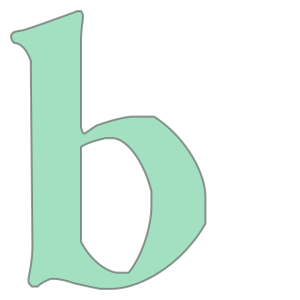

In [3]:
get_character_polygon(font_name = 'EBGaramond-Bold', glyph_name = 'b', n_points = 200)

In [4]:
def get_glyph_set(font_name):
    """
    Retrieves the glyph set from a TrueType font.

    Args:
        font_name (str): The name of the font.

    Returns:
        fontTools.ttLib.ttFont.GlyphSet: The GlyphSet object for the font.
    """
    font_path = get_font_path(font_name)
    font = TTFont(font_path)
    glyph_set = font.getGlyphSet()
    return glyph_set


def substring(line, start_dist, end_dist):
    """
    Retrieves a substring of a line.

    Args:
        line (shapely.geometry.LineString): The line to substring.
        start_dist (float): The distance along the line to start the substring.
        end_dist (float): The distance along the line to end the substring.

    Returns:
        shapely.geometry.LineString: The substring of the line.
    """
    # Ensure the start distance is smaller than the end distance
    if start_dist > end_dist:
        start_dist, end_dist = end_dist, start_dist

    # Interpolate the start and end points
    start_point = line.interpolate(start_dist)
    end_point = line.interpolate(end_dist)

    # Get the coordinates of the line
    coords = list(line.coords)

    # Find the index of the start point
    start_index = 0
    for i in range(len(coords) - 1):
        if LineString(coords[i:i+2]).distance(start_point) == 0:
            start_index = i
            break

    # Find the index of the end point
    end_index = len(coords) - 1
    for i in range(len(coords) - 1, 0, -1):
        if LineString(coords[i-1:i+1]).distance(end_point) == 0:
            end_index = i
            break

    # Return a new line string from the start to the end point
    return LineString(coords[start_index:end_index+1])


def place_text_on_path(text, font_name, line, start_dist=0, end_dist=None, n_points=100):
    """
    Places the specified text on a line.

    Args:
        text (str): The text to place.
        font_name (str): Name of the font to use.
        line (shapely.geometry.LineString): The line to place the text on.
        start_dist (float): The distance along the line to start the text.
        end_dist (float): The distance along the line to end the text. If not specified, the text will end at the end of the line.
        n_points (int): Number of points to sample from each glyph.

    Returns:
        list: A list of polygons representing the characters of the text.
    """
    if end_dist is None:
        end_dist = line.length

    # Calculate the total length of the text
    total_length = end_dist - start_dist

    # Get the font and glyph set
    font_path = get_font_path(font_name)
    font = fontTools.ttLib.TTFont(font_path)
    glyph_set = font.getGlyphSet()

    # Estimate the width of a space
    space_width = font['head'].unitsPerEm / 4

    # Calculate the width of each character
    char_widths = []
    for char in text:
        if char == " ":
            char_widths.append(space_width)
        else:
            try:
                # glyph_name = f"uni{ord(char):04X}"
                # glyph = glyph_set[glyph_name]
                glyph = get_glyph(font_name, char)
                char_widths.append(glyph.width)
            except:
                print(char)
    total_width = sum(char_widths)

    # Calculate the scale factor
    scale_factor = total_length / total_width

    # Scale the character widths
    char_widths = [width * scale_factor for width in char_widths]

    # Create a list to store the polygons
    polygons = []

    # For each character in the text
    for i, char in enumerate(text):
        
        # Calculate the start and end of the character
        char_start = start_dist + sum(char_widths[:i])
        char_end = char_start + char_widths[i]
        if char != " ":
            # Get a line for the character
            char_line = substring(line, char_start, char_end)
            position = char_line.interpolate(0.5, normalized=True)
            direction = np.array(char_line.coords[-1]) - np.array(char_line.coords[0])
            angle = math.atan2(direction[1], direction[0])

            # Get the polygon for the glyph
            glyph_polygon = get_character_polygon(font_name, char, n_points=n_points)

            # Position the polygon
            glyph_polygon = translate(glyph_polygon, xoff=position.x, yoff=position.y)
            glyph_polygon = rotate(glyph_polygon, angle, origin='centroid')

            # Add the polygon to the list
            polygons.append(glyph_polygon)

    return polygons

In [5]:
glyph_set = glyph_set = get_glyph_set('EBGaramond-Bold')

In [18]:
line = LineString([(0, 0), (1000, 100), (6000, 0)])
polygons = place_text_on_path("yo yo", 'EBGaramond-Bold', line)

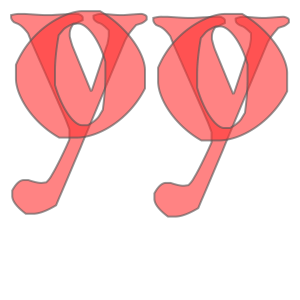

In [20]:
merge_Polygons(polygons)